In [1]:
#!pip install --upgrade oct2py
import numpy as np
import pandas as pd
from oct2py import octave
import matplotlib.pyplot as plt
import os
from scipy.optimize import root
import pickle
octave.addpath('C:/dynare/6.1/matlab') 
from IPython.display import display
#octave.addpath('/opt/homebrew/opt/dynare/lib/dynare/matlab')

    _pyeval at line 57 column 30

    _pyeval at line 57 column 30



`DyPy` is a class that we create and store in a file called `MyPy.py`. It contains methods for 

* converting data from a Dynare stucture to Numpy arrays.
* analyzing the data. 

See the file for details. 

In [2]:
from MyPy import DyPy

Creates a file called `t_call.m`. This informs Dynare of the format we want for output. It is put here so that adjusments can be made easily; for example the number of periods can be changed here rather than by looking at the `.mod` file. It is included in the `.mod` file via: `@#include "t_call.m"` in `model_1.mod`

* `order`: the order of approximation for the stochastic simulation. order=1 is a fsrst-order approximation (linearization) Higher-order approximations (e.g., order=2 for second-order) capture nonlinear effects in the model, but they require more computational resources.
* `periods`: number of periods (time steps) for which the simulation will be run. periods=1000 means that the model will be simulated for 1000 periods. The default value is 0, which means no simulation will be performed.
* `nograph`: suppresses the graphical output of the simulation results in Dynare since we draw them separatetly. 
* `irf`: the number of periods for which the impulse response functions (IRFs) will be computed and plotted. 

In [3]:
with open('t_call.m', 'w') as file:
    file.write("stoch_simul(nograph, order=1, periods=10000, irf=100);")

 `make_model.ipyn` writes a file called `t_model.m`. `t_model.m`is the `model` block in the Dynare `.mod` file. It can instead be created directlty by commenting out the next `%run` line and coding the model. `make_model.ipyn` simplifies model creation when many of the lines are very similar to each other. Then they can be written in for loops. For the model we are currently working with, there is not much advantage to writing the file via `make_model` but I have done so nonetheless. 
 
 The created file is included in the `.mod` file via `@#include "t_model.m"` in `model_1.mod`. 

In [4]:
%run make_model.ipynb

`make_files.ipynb` writes the other Dynare blocks. See that file for details. However, note that in doing so, it solves for the steady state of the model using `root` from `scipy`. If the results below do not indicate success, the `.mod` file may not run correctly. Also, note that though we solve for the steady state here, we do not give Dynare the steady state but rather use these as starting values for their ss solver. I will later code a verification the steady states are the same. 

In [5]:
%run make_files_1.ipynb

eps,tht,alf,bet,om_0,om_1,om_2,delt,psi_n,psi_k,var_a_0,var_a_1,var_a_2,rho_a_0,rho_a_1,rho_a_2


Tells octave where to find the .m file it will run. The file is `call_dynare`. Set to wherever you have this file. 




In [6]:
#a=octave.addpath(os.path.expanduser('C:/Users/blankenw/GitHub/dynare_progs/np_1'))

Makes a call to Octave, which makes a call to Dynare. Then the `.mod` file is run in Dynare. Output from Dynare is displayed as it runs.

In [7]:

# A list of dictionaries representing updates to apply to my_dict:
new_pars = [{'psi_n': 0, 'psi_k': 0}, 
           {'psi_n': 1, 'psi_k': 0}, 
           {'psi_n': 0, 'psi_k': 2}]



# Create an empty dictionary to store your variables
t=[]
with open('mf1.pkl', 'wb') as f:
    pickle.dump((ss_params,model_params,ss_shock), f)


for i, update in enumerate(new_pars):
    model_params.update(update)
    with open('mf1.pkl', 'wb') as f:
        pickle.dump((ss_params,model_params,ss_shock), f)
    %run make_files_2.ipynb
    with open('mf2.pkl', 'rb') as f:
        ss_dict = pickle.load(f)
    # Set up Octave session and run your model
    octave.dynare('model_1.mod')

    # Pull necessary structures
    oo = octave.pull('oo_')
    M_ = octave.pull('M_')
    instance = DyPy(oo,ss_dict)
    if i==0:
        oo_0=oo
    t.append(instance)


 message: The solution converged.
 success: True
  status: 1
     fun: [-1.110e-16  0.000e+00 ... -2.920e-14  2.132e-14]
       x: [ 4.368e-01  2.816e-01 ...  8.740e-01  4.816e-01]
    nfev: 43
    fjac: [[-5.762e-02 -1.287e-10 ... -3.694e-03 -4.150e-03]
           [-4.342e-02  8.220e-11 ...  5.547e-02  1.925e-03]
           ...
           [-3.699e-01 -2.624e-01 ... -2.441e-01 -2.463e-01]
           [ 7.267e-02 -7.356e-02 ...  1.403e-03  3.352e-03]]
       r: [-1.736e+01  1.018e+00 ...  4.769e-01  1.971e-01]
     qtf: [-2.940e-11  7.020e-11 ... -4.667e-13  4.077e-13]
Starting Dynare (version 6.1).
Calling Dynare with arguments: none
Starting preprocessing of the model file ...
Found 23 equation(s).
Evaluating expressions...
Computing static model derivatives (order 1).
Normalizing the static model...
Finding the optimal block decomposition of the static model...
6 block(s) found:
  5 recursive block(s) and 1 simultaneous block(s).
  the largest simultaneous block has 11 equation(s)
   

Dynare creates a `structure` which we will need so we `pull` it.

The output from Dynare is stored in a file called `oo_`. This brings `oo_` in as `oo`.

Draw all impulse response functions. 

In [8]:
def plot_dta(instances, attributes,periods=100):
    plt.figure(figsize=(15, 5))
    for j, attribute in enumerate(attributes):
        # Create a subplot for this attribute
        plt.subplot(1, len(attributes), j+1)
        for i, instance in enumerate(instances):
            # Get the attribute value (time series data)
            attr_value = getattr(instance.ir_level, attribute)
            attr_value = attr_value.reshape(-1, 1)
            length = attr_value.shape[0]
            tm = np.linspace(1, length, length)
            # Add a line to the plot for this time series
            plt.plot(tm[0:periods], attr_value[0:periods], label=labels[i])

        plt.title(attribute)
        plt.legend()

    # Show the figure with all subplots


In [9]:
n00=[]
s00=[]
for instance in t:
    n00.append(instance.ir_level.n_0_a_0)
    s00.append(instance.ir_level.s_0_a_0)
    

In [10]:
t[0].ir_level.n_0_a_0+t[0].ir_level.n_1_a_0+t[0].ir_level.n_2_a_0

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]])

In [11]:
t[0].ir_level.c_0_a_0

array([[0.88093426, 0.98358552, 1.05638934, 1.10614956, 1.13823452,
        1.15687087, 1.16537801, 1.16635506, 1.16182999, 1.15337844,
        1.14221834, 1.12928532, 1.11529261, 1.10077865, 1.08614499,
        1.07168622, 1.05761379, 1.04407478, 1.03116678, 1.01894956,
        1.00745429, 0.99669072, 0.98665288, 0.9773234 , 0.96867696,
        0.96068286, 0.95330709, 0.94651377, 0.94026635, 0.93452844,
        0.9292644 , 0.92443979, 0.92002164, 0.91597867, 0.91228138,
        0.90890209, 0.90581493, 0.90299585, 0.9004225 , 0.89807424,
        0.89593196, 0.8939781 , 0.89219645, 0.89057215, 0.88909155,
        0.88774212, 0.88651241, 0.88539192, 0.88437105, 0.88344102,
        0.88259382, 0.88182211, 0.88111921, 0.88047902, 0.87989596,
        0.87936497, 0.87888141, 0.87844105, 0.87804005, 0.8776749 ,
        0.87734239, 0.87703963, 0.87676394, 0.87651291, 0.87628435,
        0.87607623, 0.87588674, 0.87571421, 0.87555711, 0.87541408,
        0.87528385, 0.87516528, 0.87505733, 0.87

In [12]:
n0=t[1].ir_level.n_0_a_0
s0=t[1].ir_level.s_0_a_0
c0=t[1].ir_level.c_0_a_0
newstuff=n0/s0
t[1].ir_level.nstuff=newstuff


In [13]:
for instance in t:
    #loop through the instances and create an attribute for each
    instance.ir_level.ns0_a0 = instance.ir_level.n_0_a_0/instance.ir_level.s_0_a_0
    instance.ir_level.ns1_a0 = instance.ir_level.n_1_a_0/instance.ir_level.s_1_a_0
    instance.ir_level.ns2_a0 = instance.ir_level.n_2_a_0/instance.ir_level.s_2_a_0
    
    #instance.ir_level.ns0_a1 = instance.ir_level.n_0_a_1/instance.ir_level.s_0_a_1
    #instance.ir_level.ns1_a1 = instance.ir_level.n_1_a_1/instance.ir_level.s_1_a_1
    #instance.ir_level.ns2_a1 = instance.ir_level.n_2_a_1/instance.ir_level.s_2_a_1
    
    #instance.ir_level.kn0_a1 = instance.ir_level.k_0_a_1/instance.ir_level.n_0_a_1
    #instance.ir_level.kn1_a1 = instance.ir_level.k_1_a_1/instance.ir_level.n_1_a_1
    #instance.ir_level.kn2_a1 = instance.ir_level.k_2_a_1/instance.ir_level.n_2_a_1
    
    
    #instance.ir_level.y_0_a1 = instance.ir_level.c_0_a_1+instance.ir_level.i_a_1
    
    

In [14]:
instance.ir_level.k_1_a_0

array([[ 9.6313912 , 10.74819578, 11.56498876, 12.1470333 , 12.54617885,
        12.8035687 , 12.95180423, 13.01667488, 13.01854047, 12.97343584,
        12.89395318, 12.78994673, 12.66909545, 12.53735212, 12.3993016 ,
        12.25844663, 12.11743558, 11.97824385, 11.84231835, 11.71069231,
        11.58407657, 11.46293199, 11.34752686, 11.2379823 , 11.1343081 ,
        11.03643098, 10.94421675, 10.85748772, 10.77603617, 10.69963491,
        10.62804533, 10.56102358, 10.49832529, 10.43970903, 10.38493886,
        10.33378622, 10.28603112, 10.24146304, 10.19988135, 10.1610956 ,
        10.12492547, 10.09120072, 10.05976095, 10.03045526, 10.00314193,
         9.97768803,  9.95396896,  9.9318681 ,  9.91127632,  9.89209161,
         9.87421865,  9.85756839,  9.84205771,  9.82760904,  9.81415   ,
         9.80161308,  9.78993531,  9.77905798,  9.76892637,  9.75948947,
         9.75069972,  9.74251282,  9.73488748,  9.72778522,  9.72117019,
         9.71500901,  9.70927055,  9.70392584,  9.6

In [15]:
instance.ir_level.k_0_a_0

array([[ 9.6313912 , 10.74819578, 11.56498876, 12.1470333 , 12.54617885,
        12.8035687 , 12.95180423, 13.01667488, 13.01854047, 12.97343584,
        12.89395318, 12.78994673, 12.66909545, 12.53735212, 12.3993016 ,
        12.25844663, 12.11743558, 11.97824385, 11.84231835, 11.71069231,
        11.58407657, 11.46293199, 11.34752686, 11.2379823 , 11.1343081 ,
        11.03643098, 10.94421675, 10.85748772, 10.77603617, 10.69963491,
        10.62804533, 10.56102358, 10.49832529, 10.43970903, 10.38493886,
        10.33378622, 10.28603112, 10.24146304, 10.19988135, 10.1610956 ,
        10.12492547, 10.09120072, 10.05976095, 10.03045526, 10.00314193,
         9.97768803,  9.95396896,  9.9318681 ,  9.91127632,  9.89209161,
         9.87421865,  9.85756839,  9.84205771,  9.82760904,  9.81415   ,
         9.80161308,  9.78993531,  9.77905798,  9.76892637,  9.75948947,
         9.75069972,  9.74251282,  9.73488748,  9.72778522,  9.72117019,
         9.71500901,  9.70927055,  9.70392584,  9.6

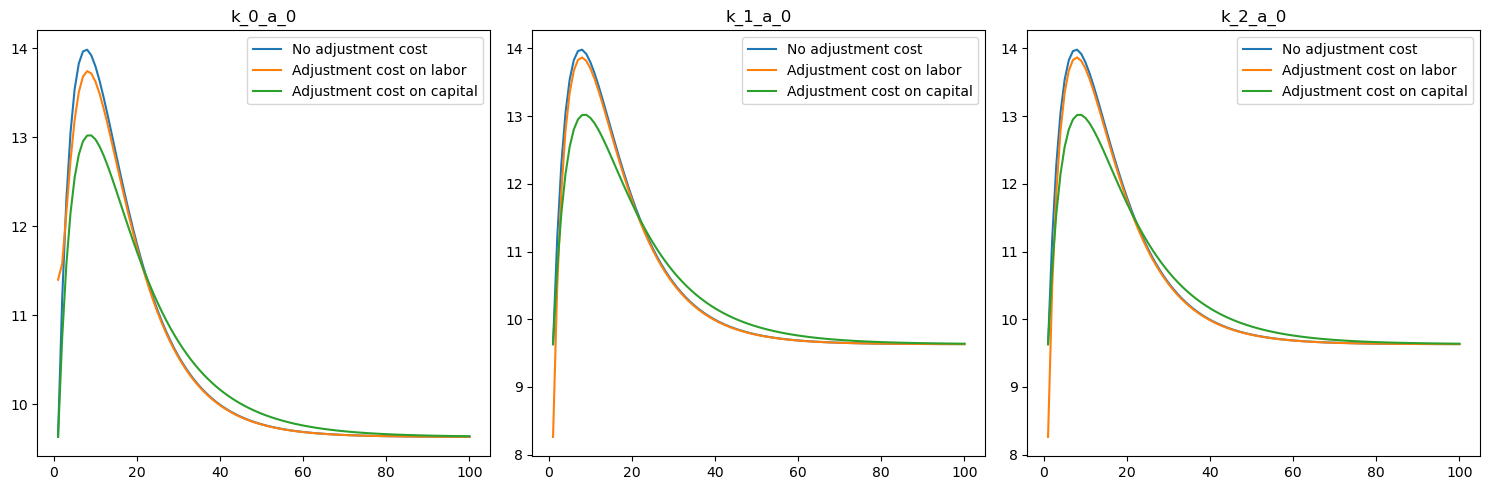

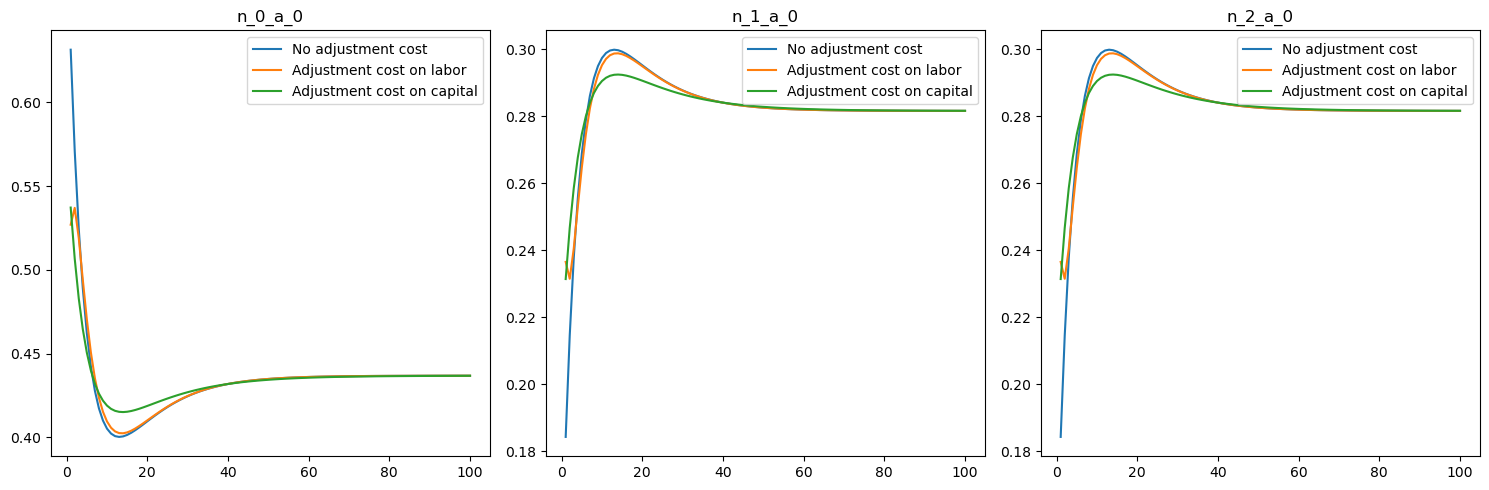

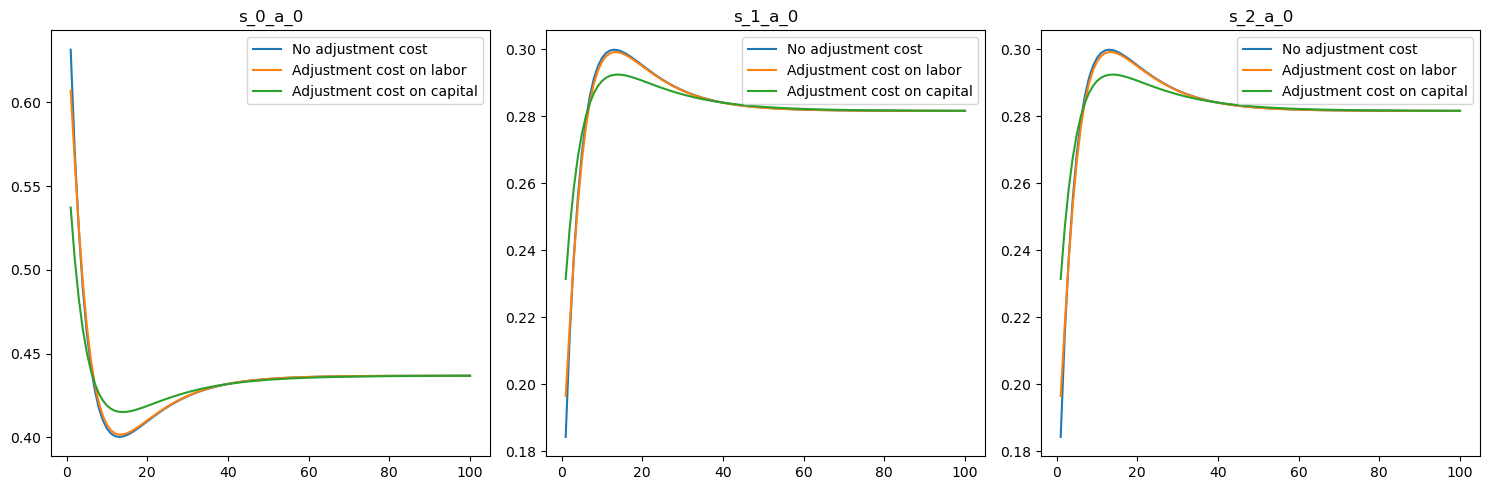

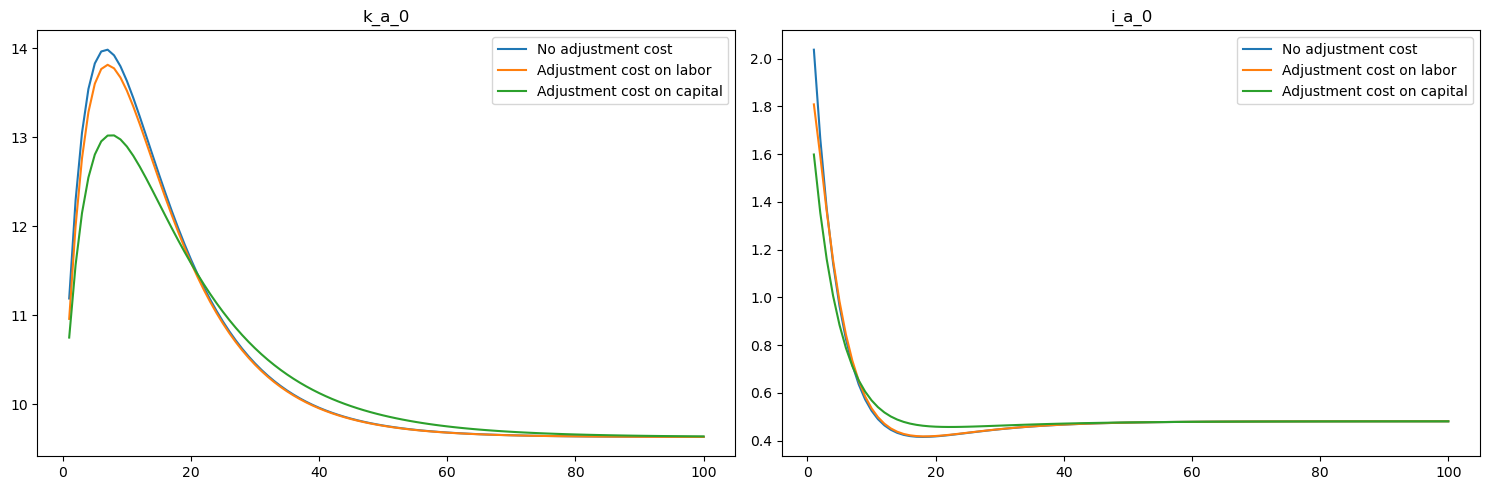

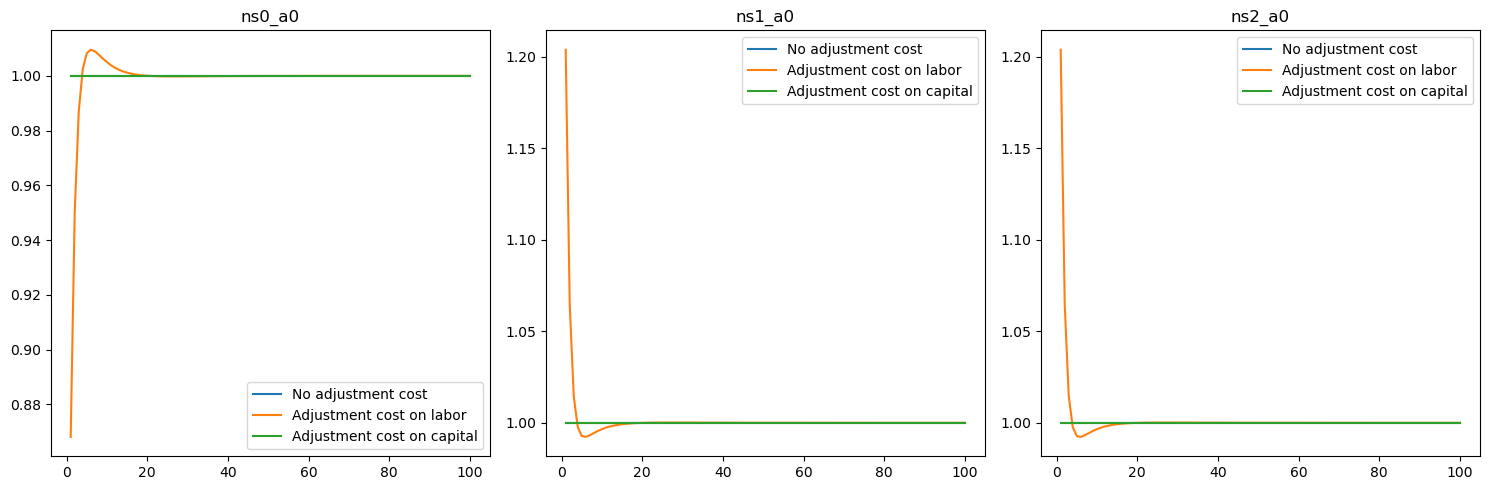

In [16]:
labels = ['No adjustment cost', 'Adjustment cost on labor', 'Adjustment cost on capital']

all_attributes =[   #['y_a_0', 'y_a_1', 'y_a_2'],
                    #['y_0_a_0', 'y_0_a_1', 'y_0_a_2'],
                    #['r_a_0', 'r_a_1', 'r_a_2'],
                    #['tot_a_0', 'tot_a_1', 'tot_a_2'],
                    #['sc_a_0', 'sc_a_1', 'sc_a_2'],
                    #['win_a_0', 'win_a_1', 'win_a_2'],
                    ['k_0_a_0', 'k_1_a_0', 'k_2_a_0'],
                    ['n_0_a_0', 'n_1_a_0', 'n_2_a_0'],
                    #['n_0_a_1', 'n_1_a_1', 'n_2_a_1'],
                    ['s_0_a_0', 's_1_a_0', 's_2_a_0'],
                    ['k_a_0', 'i_a_0'],
                    #['k_0_a_1', 'k_1_a_1', 'k_2_a_1'],
                    #['c_0_a_1', 'c_1_a_1', 'c_2_a_1'],
                    #['k_a_1', 'i_a_1'],
                    #['k_0_a_2', 'k_1_a_2', 'k_2_a_2'],
                    #['c_0_a_2', 'c_1_a_2', 'c_2_a_2'],
                    #['k_a_2', 'i_a_2'],
                    ['ns0_a0', 'ns1_a0', 'ns2_a0'],
                    #['ns0_a1', 'ns1_a1', 'ns2_a1'],
                   # ['kn0_a1', 'kn1_a1', 'kn2_a1'],
                     ]
for attributes in all_attributes:
    plot_dta(t, attributes,periods=100)
    plt.tight_layout()
    plt.show()                  



In [17]:
k=1
n_0=t[k].ir_level.n_0_a_0
n_1=t[k].ir_level.n_1_a_0
n_2=t[k].ir_level.n_2_a_0
s_0=t[k].ir_level.s_0_a_0
s_1=t[k].ir_level.s_1_a_0
s_2=t[k].ir_level.s_2_a_0
k_0=t[k].ir_level.k_a_0
k_0=t[k].ir_level.k_0_a_0
k_1=t[k].ir_level.k_1_a_0
k_2=t[k].ir_level.k_2_a_0
c_0=t[k].ir_level.c_0_a_0
c_1=t[k].ir_level.c_1_a_0
c_2=t[k].ir_level.c_2_a_0
i=t[k].ir_level.i_a_0
a_0=t[k].ir_level.a_0_a_0
a_1=t[k].ir_level.a_1_a_0
a_2=t[k].ir_level.a_2_a_0


In [18]:
eps=ss_params['eps']
tht=ss_params['tht']
alf=ss_params['alf']
bet=ss_params['bet']
om_0=ss_params['om_0']
om_1=ss_params['om_1']
om_2=ss_params['om_2']
delt=ss_params['delt']
psi_n=ss_params['psi_n']
psi_k=ss_params['psi_k']


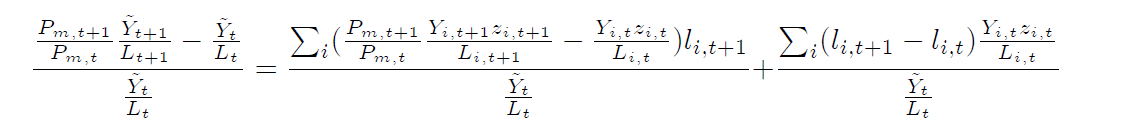

In [19]:
out=[]

In [20]:

# Define a function to highlight the diagonal
def highlight_diagonal(x):
	df = pd.DataFrame('', index=x.index, columns=x.columns)
	np.fill_diagonal(df.values, 'background-color: yellow')
	return df

# Iterate through the list and process each element
for i in range(len(t)):
	data = t[i].var

	# Convert to DataFrame
	df = pd.DataFrame(data)

	# Set the index and columns names from ss_dict
	df.index = ss_dict.keys()
	df.columns = ss_dict.keys()

	# Apply the highlighting function to the DataFrame and round to three digits
	styled_df = df.style.apply(highlight_diagonal, axis=None).format(precision=3)
	
	# Set smaller font size
	styled_df = styled_df.set_table_styles([{
		'selector': 'table',
		'props': [('font-size', '6pt')]
	}])
	
	# Display the styled DataFrame
	display(styled_df)

,n_0,n_1,n_2,s_0,s_1,s_2,k,k_0,k_1,k_2,c_0,c_1,c_2,i,y_0,y,r,tot,sc,win,a_0,a_1,a_2
n_0,0.085,-0.042,-0.042,0.085,-0.042,-0.042,-0.288,-0.945,-0.945,-0.945,-0.061,-0.174,-0.174,0.610,0.549,0.655,0.000,-0.018,-0.018,0.000,0.260,0.000,0.000
n_1,-0.042,0.021,0.021,-0.042,0.021,0.021,0.144,0.473,0.473,0.473,0.030,0.087,0.087,-0.305,-0.275,-0.328,0.000,0.009,0.009,0.000,-0.130,0.000,0.000
n_2,-0.042,0.021,0.021,-0.042,0.021,0.021,0.144,0.473,0.473,0.473,0.030,0.087,0.087,-0.305,-0.275,-0.328,0.000,0.009,0.009,0.000,-0.130,0.000,0.000
s_0,0.085,-0.042,-0.042,0.085,-0.042,-0.042,-0.288,-0.945,-0.945,-0.945,-0.061,-0.174,-0.174,0.610,0.549,0.655,0.000,-0.018,-0.018,0.000,0.260,0.000,0.000
s_1,-0.042,0.021,0.021,-0.042,0.021,0.021,0.144,0.473,0.473,0.473,0.030,0.087,0.087,-0.305,-0.275,-0.328,0.000,0.009,0.009,0.000,-0.130,0.000,0.000
s_2,-0.042,0.021,0.021,-0.042,0.021,0.021,0.144,0.473,0.473,0.473,0.030,0.087,0.087,-0.305,-0.275,-0.328,0.000,0.009,0.009,0.000,-0.130,0.000,0.000
k,-0.288,0.144,0.144,-0.288,0.144,0.144,235.657,233.006,233.006,233.006,15.690,11.019,11.019,14.301,29.992,70.715,0.000,-2.000,-2.000,0.000,10.690,0.000,0.000
k_0,-0.945,0.473,0.473,-0.945,0.473,0.473,233.006,235.552,235.552,235.552,15.838,12.154,12.154,9.232,25.070,64.116,0.000,-1.818,-1.818,0.000,8.431,0.000,0.000
k_1,-0.945,0.473,0.473,-0.945,0.473,0.473,233.006,235.552,235.552,235.552,15.838,12.154,12.154,9.232,25.070,64.116,0.000,-1.818,-1.818,0.000,8.431,0.000,0.000
k_2,-0.945,0.473,0.473,-0.945,0.473,0.473,233.006,235.552,235.552,235.552,15.838,12.154,12.154,9.232,25.070,64.116,0.000,-1.818,-1.818,0.000,8.431,0.000,0.000


,n_0,n_1,n_2,s_0,s_1,s_2,k,k_0,k_1,k_2,c_0,c_1,c_2,i,y_0,y,r,tot,sc,win,a_0,a_1,a_2
n_0,0.045,-0.022,-0.022,0.056,-0.028,-0.028,-0.374,-0.559,-0.981,-0.981,-0.047,-0.114,-0.114,0.383,0.335,0.373,0.000,-0.004,-0.004,0.000,0.174,0.000,0.000
n_1,-0.022,0.011,0.011,-0.028,0.014,0.014,0.187,0.280,0.490,0.490,0.024,0.057,0.057,-0.191,-0.168,-0.187,0.000,0.002,0.002,0.000,-0.087,0.000,0.000
n_2,-0.022,0.011,0.011,-0.028,0.014,0.014,0.187,0.280,0.490,0.490,0.024,0.057,0.057,-0.191,-0.168,-0.187,0.000,0.002,0.002,0.000,-0.087,0.000,0.000
s_0,0.056,-0.028,-0.028,0.074,-0.037,-0.037,-0.293,-0.455,-1.169,-1.169,-0.048,-0.139,-0.139,0.521,0.473,0.559,0.000,-0.005,-0.005,0.000,0.246,0.000,0.000
s_1,-0.028,0.014,0.014,-0.037,0.018,0.018,0.147,0.227,0.585,0.585,0.024,0.070,0.070,-0.261,-0.237,-0.279,0.000,0.003,0.003,0.000,-0.123,0.000,0.000
s_2,-0.028,0.014,0.014,-0.037,0.018,0.018,0.147,0.227,0.585,0.585,0.024,0.070,0.070,-0.261,-0.237,-0.279,0.000,0.003,0.003,0.000,-0.123,0.000,0.000
k,-0.374,0.187,0.187,-0.293,0.147,0.147,218.209,217.736,214.575,214.575,14.589,10.316,10.316,13.051,27.640,65.365,0.000,-1.724,-1.724,0.000,9.943,0.000,0.000
k_0,-0.559,0.280,0.280,-0.455,0.227,0.227,217.736,219.070,214.987,214.987,14.645,10.622,10.622,11.804,26.449,63.787,0.000,-1.677,-1.677,0.000,9.420,0.000,0.000
k_1,-0.981,0.490,0.490,-1.169,0.585,0.585,214.575,214.987,222.375,222.375,14.670,11.611,11.611,6.385,21.055,56.514,0.000,-1.624,-1.624,0.000,6.617,0.000,0.000
k_2,-0.981,0.490,0.490,-1.169,0.585,0.585,214.575,214.987,222.375,222.375,14.670,11.611,11.611,6.385,21.055,56.514,0.000,-1.624,-1.624,0.000,6.617,0.000,0.000


,n_0,n_1,n_2,s_0,s_1,s_2,k,k_0,k_1,k_2,c_0,c_1,c_2,i,y_0,y,r,tot,sc,win,a_0,a_1,a_2
n_0,0.025,-0.013,-0.013,0.025,-0.013,-0.013,-0.404,-0.661,-0.661,-0.661,-0.011,-0.069,-0.069,0.224,0.214,0.310,0.000,-0.013,-0.013,0.000,0.134,0.000,0.000
n_1,-0.013,0.006,0.006,-0.013,0.006,0.006,0.202,0.331,0.331,0.331,0.005,0.035,0.035,-0.112,-0.107,-0.155,0.000,0.007,0.007,0.000,-0.067,0.000,0.000
n_2,-0.013,0.006,0.006,-0.013,0.006,0.006,0.202,0.331,0.331,0.331,0.005,0.035,0.035,-0.112,-0.107,-0.155,0.000,0.007,0.007,0.000,-0.067,0.000,0.000
s_0,0.025,-0.013,-0.013,0.025,-0.013,-0.013,-0.404,-0.661,-0.661,-0.661,-0.011,-0.069,-0.069,0.224,0.214,0.310,0.000,-0.013,-0.013,0.000,0.134,0.000,0.000
s_1,-0.013,0.006,0.006,-0.013,0.006,0.006,0.202,0.331,0.331,0.331,0.005,0.035,0.035,-0.112,-0.107,-0.155,0.000,0.007,0.007,0.000,-0.067,0.000,0.000
s_2,-0.013,0.006,0.006,-0.013,0.006,0.006,0.202,0.331,0.331,0.331,0.005,0.035,0.035,-0.112,-0.107,-0.155,0.000,0.007,0.007,0.000,-0.067,0.000,0.000
k,-0.404,0.202,0.202,-0.404,0.202,0.202,167.910,166.469,166.469,166.469,11.739,8.180,8.180,9.764,21.504,52.102,0.000,-1.554,-1.554,0.000,8.146,0.000,0.000
k_0,-0.661,0.331,0.331,-0.661,0.331,0.331,166.469,167.843,167.843,167.843,11.448,8.641,8.641,7.018,18.466,46.976,0.000,-1.356,-1.356,0.000,6.424,0.000,0.000
k_1,-0.661,0.331,0.331,-0.661,0.331,0.331,166.469,167.843,167.843,167.843,11.448,8.641,8.641,7.018,18.466,46.976,0.000,-1.356,-1.356,0.000,6.424,0.000,0.000
k_2,-0.661,0.331,0.331,-0.661,0.331,0.331,166.469,167.843,167.843,167.843,11.448,8.641,8.641,7.018,18.466,46.976,0.000,-1.356,-1.356,0.000,6.424,0.000,0.000


In [21]:
oo

{'dynare_version': '6.1',
 'exo_simul': array([[-0.86609021,  0.        ,  0.        ],
        [ 0.54011476,  0.        ,  0.        ],
        [-0.29629416,  0.        ,  0.        ],
        ...,
        [ 0.11636288,  0.        ,  0.        ],
        [-0.0032429 ,  0.        ,  0.        ],
        [-0.03002322,  0.        ,  0.        ]]),
 'endo_simul': array([[ 3.13830967e-01,  4.27917729e-01,  3.91574182e-01, ...,
          4.55372145e-01,  5.07736278e-01,  5.41993104e-01],
        [ 3.43084517e-01,  2.86041135e-01,  3.04212909e-01, ...,
          2.72313928e-01,  2.46131861e-01,  2.29003448e-01],
        [ 3.43084517e-01,  2.86041135e-01,  3.04212909e-01, ...,
          2.72313928e-01,  2.46131861e-01,  2.29003448e-01],
        ...,
        [-8.66090214e-01, -1.52757416e-01, -4.18500095e-01, ...,
         -1.61721442e+00, -1.29701444e+00, -1.06763477e+00],
        [-2.92825019e-17,  7.25625027e-17,  6.97899770e-17, ...,
          1.33421951e-15,  1.36818609e-15,  1.37005413e-

In [22]:
print(t[1].ir_level.win_a_0[0][0:4])
print(t[1].ir_level.tot_a_0[0][0:4])
print(t[1].ir_level.sc_a_0[0][0:4])

[-2.98283078e-16 -9.36663780e-16 -1.15581877e-15 -1.27145312e-15]
[-0.0130265  -0.03468276 -0.04172583 -0.04256918]
[-0.0130265  -0.03468276 -0.04172583 -0.04256918]


In [23]:
print(t[1].ir_level.n_0_a_0[0])

[0.52692362 0.53699112 0.51898238 0.49412229 0.4705094  0.45075486
 0.43526677 0.42364438 0.41525537 0.40946296 0.40570524 0.40351397
 0.40251028 0.40239264 0.40292373 0.40391827 0.40523267 0.40675647
 0.40840542 0.41011589 0.41184044 0.41354425 0.41520235 0.41679738
 0.41831783 0.41975666 0.4211102  0.42237733 0.42355876 0.42465658
 0.42567379 0.42661402 0.42748132 0.42827992 0.42901416 0.42968834
 0.43030668 0.43087324 0.43139193 0.43186645 0.43230026 0.43269666
 0.43305868 0.43338917 0.43369076 0.43396589 0.43421681 0.4344456
 0.43465416 0.43484424 0.43501745 0.43517527 0.43531904 0.43545001
 0.43556929 0.43567793 0.43577686 0.43586695 0.43594898 0.43602366
 0.43609167 0.43615357 0.43620994 0.43626125 0.43630796 0.43635048
 0.43638919 0.43642442 0.43645649 0.43648569 0.43651226 0.43653645
 0.43655847 0.43657851 0.43659675 0.43661336 0.43662847 0.43664222
 0.43665474 0.43666614 0.43667651 0.43668595 0.43669454 0.43670237
 0.43670948 0.43671596 0.43672186 0.43672723 0.43673211 0.43673

In [24]:
print(t[1].ir_dif.n_1_a_0[0])

[-4.50710039e-02 -5.01047565e-02 -4.11003874e-02 -2.86703392e-02
 -1.68638938e-02 -6.98662373e-03  7.57420286e-04  6.56861477e-03
  1.07631199e-02  1.36593246e-02  1.55381867e-02  1.66338172e-02
  1.71356643e-02  1.71944829e-02  1.69289377e-02  1.64316680e-02
  1.57744690e-02  1.50125680e-02  1.41880931e-02  1.33328579e-02
  1.24705862e-02  1.16186813e-02  1.07896299e-02  9.99211419e-03
  9.23188929e-03  8.51247593e-03  7.83570443e-03  7.20214135e-03
  6.61142295e-03  6.06251455e-03  5.55391159e-03  5.08379437e-03
  4.65014646e-03  4.25084436e-03  3.88372481e-03  3.54663443e-03
  3.23746577e-03  2.95418263e-03  2.69483731e-03  2.45758155e-03
  2.24067267e-03  2.04247621e-03  1.86146586e-03  1.69622148e-03
  1.54542574e-03  1.40785988e-03  1.28239876e-03  1.16800564e-03
  1.06372680e-03  9.68686059e-04  8.82079472e-04  8.03170124e-04
  7.31283146e-04  6.65800974e-04  6.06158863e-04  5.51840678e-04
  5.02374949e-04  4.57331198e-04  4.16316533e-04  3.78972484e-04
  3.44972089e-04  3.14017